# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка к работе

In [1]:
!pip install phik -q
#!pip install numpy==1.23.1 -q
#!pip install numba -U -q
!pip install scikit-learn -U -q 
#!pip install scipy -U -q 
#!pip install shap -U -q

In [2]:
!pip install catboost
!pip install lightgbm

In [3]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

import time

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
)

from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix

import lightgbm as lgb

from catboost import CatBoostRegressor, Pool, metrics, cv


from scipy import stats as st

# import shap

from phik.report import plot_correlation_matrix
from phik import report

import warnings

In [4]:
RANDOM_STATE = 2024

state = np.random.RandomState(RANDOM_STATE)

## Загрузка и обзор данных
### Загрузка данных

In [5]:
df = pd.read_csv('...', parse_dates=['DateCrawled','DateCreated','LastSeen'])

### Обзор данных

In [6]:
display(df.head())
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

Как видно данные совпадают с предоставленным описанием структуры данных. Типы данных, за исключением столбцов с датами, выбраны корректно

## Предобработка данных

В этом разделе рассмотрим пропуски в данных и проведем необходимые преобразования типов и добавим необходимые столбцы.

### Рассмотрение пропусков в данных

Рассмотрим в каких каких столбцах сколько пропусков находится

In [7]:
print(df.isna().sum())

print('Всего строк:', df.shape[0])

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
Всего строк: 354369


Как видно в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` присутствуют пропуски. Все эти столбцы содержат категориальные признаки и заполнить их не представляется возможным (так например пропуски в `Gearbox` могут быть как действительно пропусками, так и например машины с роботами и вариаторами в случае если `auto` обозначат гидромеханический автомат). Однако можно предположить, что пропуски в столбце `Repaired` означает `no` (это точно неизвестно, но используем это предположение)

Удаление строк с пропусками так же не лучшее решение т.к. они могут составлять до 20% исходных данных.

In [8]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['Repaired'] = df['Repaired'].fillna('no')

### Дубликаты в данных

Рассмотрим явные и неявные дубликаты в данных

In [9]:
print('Число явных дубликатов:', df.duplicated().sum())
df = df.drop_duplicates()

print(df['VehicleType'].unique())
print(df['Gearbox'].unique())
print(df['FuelType'].unique())
print(df['Repaired'].unique())

df['FuelType'] = df['FuelType'].replace('petrol','gasoline')

Число явных дубликатов: 5
['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
['manual' 'auto' 'unknown']
['petrol' 'gasoline' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']
['no' 'yes']


В данных есть несколько явных дубликатов (удалим их), и присутсвует неявный дубликат `petrol`-`gasoline`

### Преобразование типов

Столбцы с датами были преобразованы к типу `datetime` при импорте

In [10]:
try:
    pass
    #df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
    #df['DateCreated'] = pd.to_datetime(df['DateCreated'])
    #df['LastSeen'] = pd.to_datetime(df['LastSeen'])
except:
    pass
display(df.head())
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,gasoline,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354364 non-null  datetime64[ns]
 1   Price              354364 non-null  int64         
 2   VehicleType        354364 non-null  object        
 3   RegistrationYear   354364 non-null  int64         
 4   Gearbox            354364 non-null  object        
 5   Power              354364 non-null  int64         
 6   Model              354364 non-null  object        
 7   Kilometer          354364 non-null  int64         
 8   RegistrationMonth  354364 non-null  int64         
 9   FuelType           354364 non-null  object        
 10  Brand              354364 non-null  object        
 11  Repaired           354364 non-null  object        
 12  DateCreated        354364 non-null  datetime64[ns]
 13  NumberOfPictures   354364 non-null  int64   

### Итоги предобработки данных

В ходе предобработки данных были обнаружены пропуски, заполнить или удалить которые не представляется возможным. Твкже были удалены явные дубликаты и проведено преобразование типов для дат

## Исследовательский анализ данных
Опишем общую информацию о распределениях данных в таблице

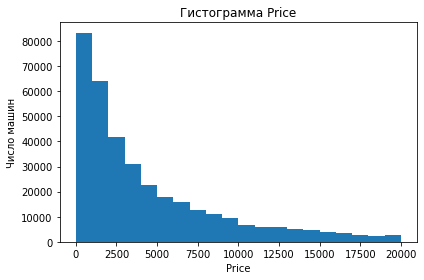

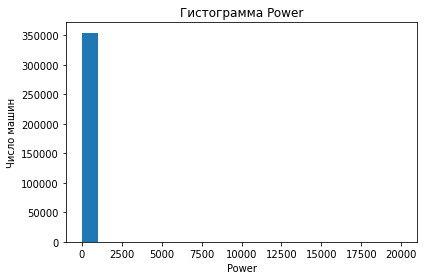

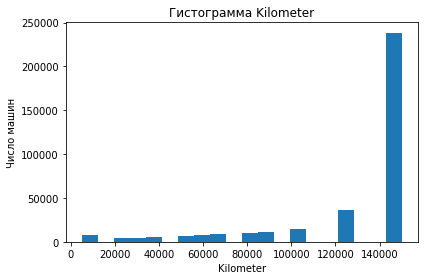

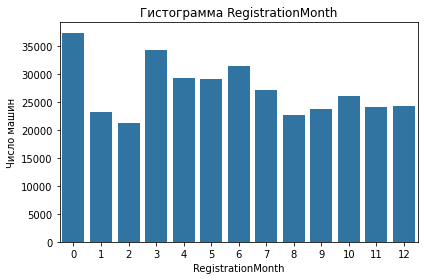

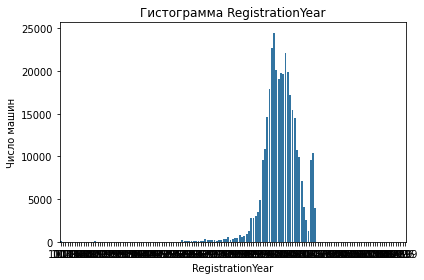

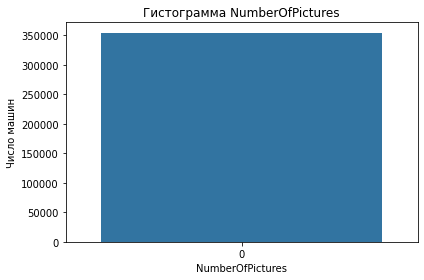

Годы регистрации: 1000 - 9999


In [11]:
discrete_columns = ['RegistrationMonth', 'RegistrationYear', 'NumberOfPictures']

for c in df.drop(['PostalCode']+discrete_columns, axis=1).select_dtypes(include=np.number).columns.tolist():
    fig, ax = plt.subplots()
    ax.hist(df[c], bins=20)
    
    ax.set_xlabel(c)
    ax.set_ylabel('Число машин')
    ax.set_title('Гистограмма '+c)
    fig.tight_layout()
    plt.show()
    
for c in discrete_columns:
    fig, ax = plt.subplots()
    sns.countplot(x=df[c], ax=ax, color='tab:blue')
    ax.set_xlabel(c)
    ax.set_ylabel('Число машин')
    ax.set_title('Гистограмма '+c)
    fig.tight_layout()
    plt.show()
    
print('Годы регистрации:', df['RegistrationYear'].min(),'-',df['RegistrationYear'].max())

По гистограммам сразу видно что в столбце `Power` есть аномальные значения. Сразу удалим объявления о всех авто с мощностью более 500л.с. как аномальные.

Также заметим что подозрительно много машин с пробегом 150000км, но машин с бОльшим пробегом нет. По видимому для них указывается максимальное значение пробега в 150000.

Это вносит искажения в данные поэтому придется привести пробег к категориальному типу, для простоты выберем следующие категории:
- `до 50 т.км`
- `50-150 т.км`
- `150+`

Отфильтруем годы регистрации от 1970 до 2024

Также заметим что для всех данных число фото в объявлении 0, по видимому произошла какая-то ошибка при сборе данных. Для дальнейшей работы этот столбец неинформативен поэтому удалим его

In [12]:
discrete_columns = ['RegistrationMonth', 'RegistrationYear']
df = df.drop('NumberOfPictures', axis=1)
df = df[df['Power']<500]
df = df[(df['RegistrationYear']<=2024)&(df['RegistrationYear']>1970)]

df['kmtype'] = df['Kilometer'].apply(lambda x: '150+' if x>=150000 else ('50-' if x<=50000 else '50-150'))


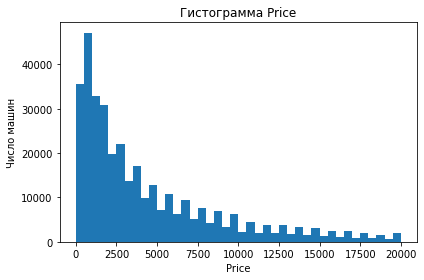

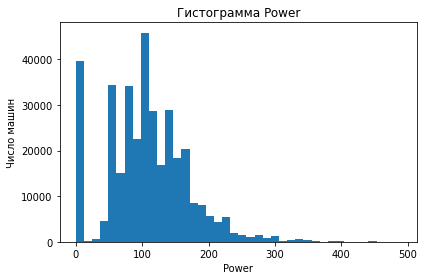

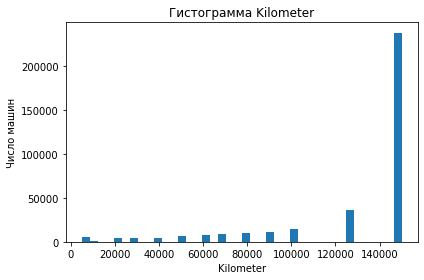

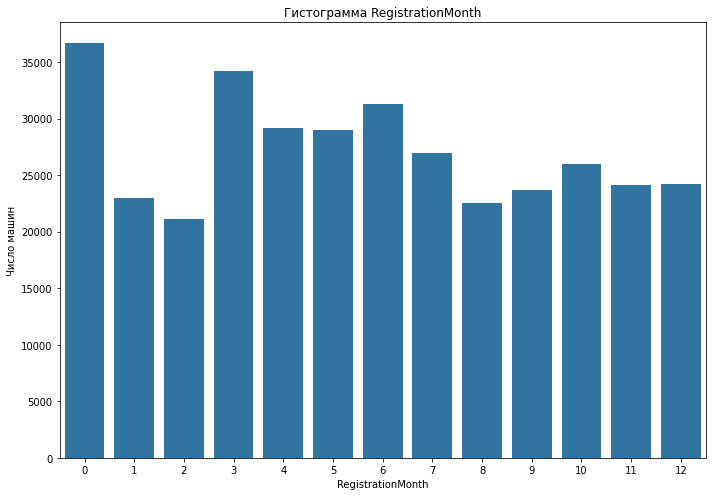

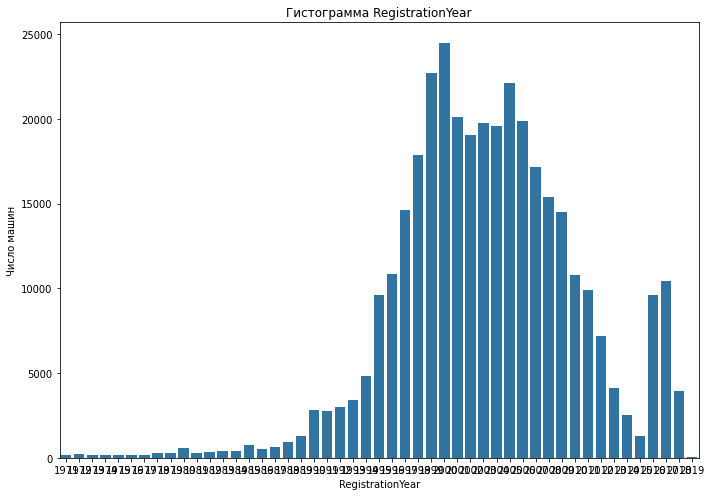

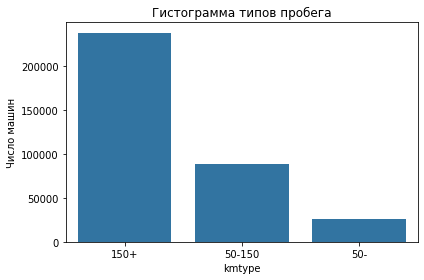

In [13]:
for c in df.drop(['PostalCode']+discrete_columns, axis=1).select_dtypes(include=np.number).columns.tolist():
    fig, ax = plt.subplots()
    ax.hist(df[c], bins=40)
    
    ax.set_xlabel(c)
    ax.set_ylabel('Число машин')
    ax.set_title('Гистограмма '+c)
    fig.tight_layout()
    plt.show()
    
for c in discrete_columns:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 7)
    sns.countplot(x=df[c], ax=ax, color='tab:blue')
    ax.set_xlabel(c)
    ax.set_ylabel('Число машин')
    ax.set_title('Гистограмма '+c)
    fig.tight_layout()
    plt.show()
    
fig, ax = plt.subplots()
sns.countplot(x=df['kmtype'], ax=ax, color='tab:blue')
ax.set_xlabel('kmtype')
ax.set_ylabel('Число машин')
ax.set_title('Гистограмма типов пробега')
fig.tight_layout()
plt.show()

Заметим, что в данных много машин с 0 мощностью, что явно является аномалией, удалить их некорректно т.к. их достаточно много. Можно попробовать для них заменить заменить мощность на среднюю для модели

39389
1
0


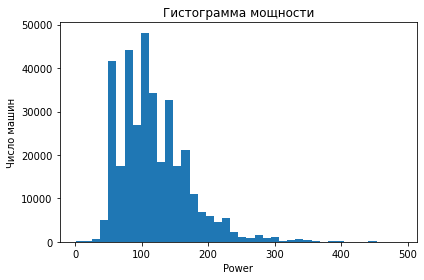

In [14]:
print(df.loc[(df['Power']==0), 'Price'].count())
#print(df.loc[(df['Power'].isna()), 'Price'].count())

mean_model_power = df.groupby('Model')['Power'].mean().astype(int)

df.loc[(df['Power']==0), 'Power'] = df[(df['Power']==0)].apply(lambda x: mean_model_power[x['Model']], axis=1)

print(df.loc[(df['Power']==0), 'Price'].count())
#print(df.loc[(df['Power'].isna()), 'Price'].count())

#для 1 машины восстановление мощности по модели не вышло, удалим ее

df = df[df['Power']>0]
print(df.loc[(df['Power']==0), 'Price'].count())

fig, ax = plt.subplots()
ax.hist(df['Power'], bins=40)
ax.set_xlabel('Power')
ax.set_ylabel('Число машин')
ax.set_title('Гистограмма мощности')
fig.tight_layout()
plt.show()

Также рассмотрим число объявлений с нулевой ценой

In [15]:
print(df.loc[df['Price']==0, 'Price'].count())

df = df[df['Price']>0]

print(df.loc[df['Price']==0, 'Price'].count())

10511
0


Таких объявлений не так много (3%) и вполне допустимо их удалить

Рассотрим годы регистрации и данные о датах в объявлении

In [16]:
print('Максимальный год в DateCrawled:', df['DateCrawled'].dt.year.max())
print('Максимальный год в DateCreated:', df['DateCreated'].dt.year.max())
print('Максимальный год в LastSeen:', df['LastSeen'].dt.year.max())

Максимальный год в DateCrawled: 2016
Максимальный год в DateCreated: 2016
Максимальный год в LastSeen: 2016


Как видно, даты в объявлениях ограничены 2016 годом, однако в данных есть более поздние годы регистрации, что является аномалией

In [17]:
print('Число авто с регистрацией после 2016:', df.loc[df['RegistrationYear']>2016,'Price'].count())

Число авто с регистрацией после 2016: 13666


Таких объявлений около 5% и их можно удалить

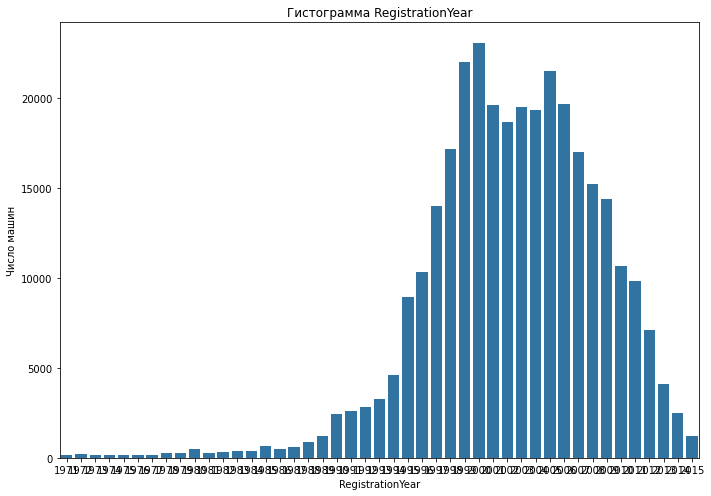

In [18]:
df = df[df['RegistrationYear']<2016]

c = 'RegistrationYear'
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.countplot(x=df[c], ax=ax, color='tab:blue')
ax.set_xlabel(c)
ax.set_ylabel('Число машин')
ax.set_title('Гистограмма '+c)
fig.tight_layout()
plt.show()

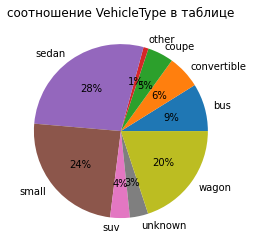

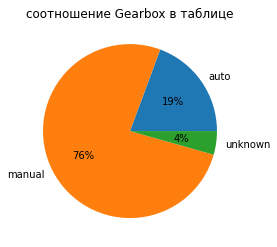

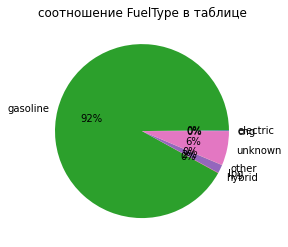

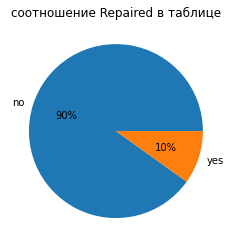

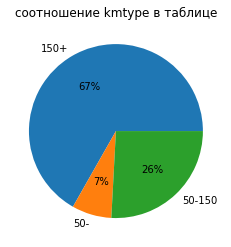

In [19]:
for c in df.drop(['Model','Brand'],axis=1).select_dtypes(include='object'):
    df.fillna('NaN').pivot_table(index=c, aggfunc='count').plot(y='Price', kind='pie', autopct='%1.0f%%', legend=False, ylabel='', title='соотношение '+c+' в таблице')
    plt.show()

### Корреляционный анализ

Построим матрицу коэффициентов корреляции $\varphi_K$ (дату публицации и сбора не учитываем)

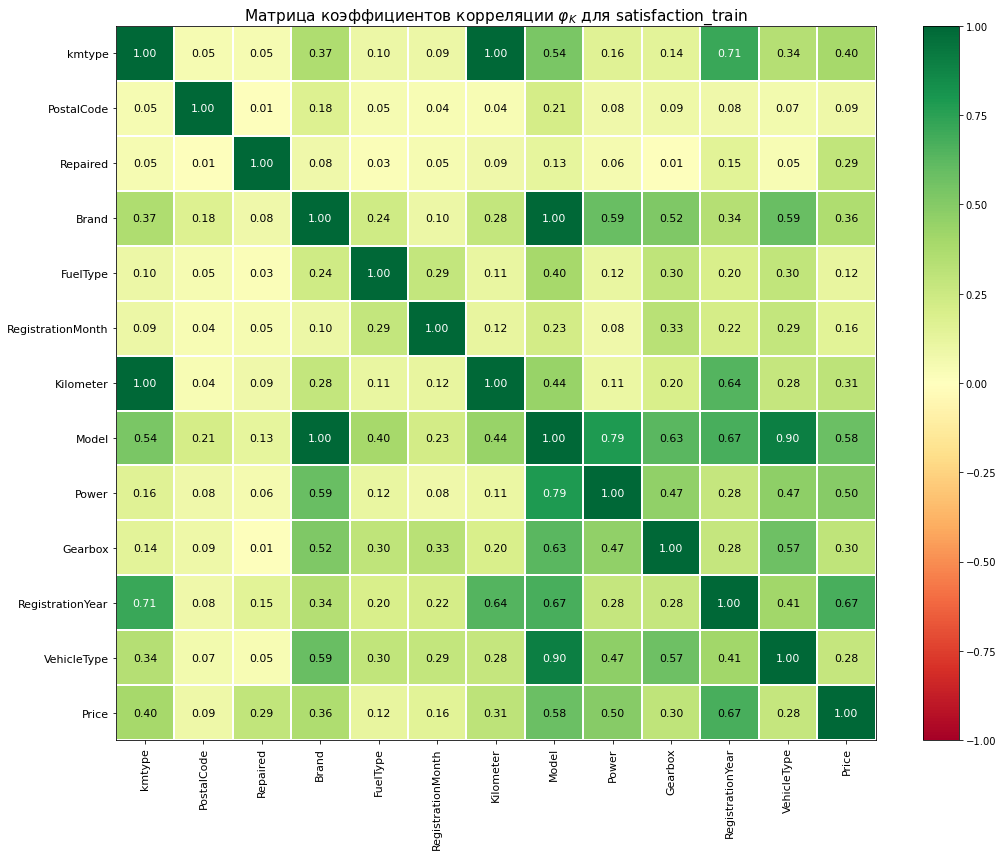

In [20]:
interval_cols = df.drop(discrete_columns, axis=1).select_dtypes(include='number')

phik_overview = df.drop(['DateCrawled','DateCreated','LastSeen'],axis=1).phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица коэффициентов корреляции $\varphi_K$ для satisfaction_train",
    fontsize_factor=1.1,
    figsize=(15, 12)
)


## Обучение моделей

В данном разделе обучим несколько моделей регресии для целевого параметра `Price` и выберем из них лучшую

Для оценки качества модели будем использовать метрику RMSE

В данных имеются мультиколлинеарные признаки `Kilometer`-`kmtype` и `Brand`-`Model`. Всего признаков не так много поэтому для линейной модели это не так критично, к тому же LightGBM и Catboost использут модели деревьев для которых мультиколлинеарность не проблема. 

При обучении не будем учитывать признак `NumberOfPictures` т.к. он неинформативен (содержит одни нули).

Также будем игнорировать временные признаки (`DateCrawled`, `DateCreated`, `LastSeen`) т.к. с ними сложно и на данный момент неизвестно как работать

In [21]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,kmtype
0,2016-03-24 11:52:17,480,unknown,1993,manual,95,golf,150000,0,gasoline,volkswagen,no,2016-03-24,70435,2016-04-07 03:16:57,150+
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,50-150
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,90480,2016-04-05 12:47:46,50-150
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,150+
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,50-150


In [22]:
cat_columns = ['VehicleType','Gearbox','Model','Brand','FuelType','Repaired','PostalCode','kmtype']
num_columns = ['RegistrationYear','Power','RegistrationMonth','Kilometer']
date_columns = []#['DateCrawled','DateCreated','LastSeen']

# train/valid/test: 60%/20%/20%

X_train, X_test, y_train, y_test = train_test_split(
    df[cat_columns+num_columns+date_columns],
    df['Price'],
    test_size = 0.4, 
    random_state = RANDOM_STATE)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test,
    y_test,
    test_size = 0.5, 
    random_state = RANDOM_STATE)

display(X_train.head())

display(y_train.head())

,VehicleType,Gearbox,Model,Brand,FuelType,Repaired,PostalCode,kmtype,RegistrationYear,Power,RegistrationMonth,Kilometer
58385,wagon,manual,a4,audi,gasoline,no,66701,150+,1998,150,10,150000
158107,sedan,manual,golf,volkswagen,gasoline,no,55270,50-150,2011,105,5,125000
263596,convertible,manual,other,audi,gasoline,no,24118,150+,2002,170,10,150000
53061,small,manual,ka,ford,gasoline,no,23845,150+,2005,60,8,150000
121892,sedan,manual,other,citroen,gasoline,no,63607,50-150,1998,90,10,125000


58385      1111
158107    11500
263596     4800
53061      1499
121892      720
Name: Price, dtype: int64

### SKLearn LinearRegression

Для данной задачи выберем модель LinearRegression

Для кодирования категориальных признаков предпочтительнее использовать кодировщик OHE т.к. в данном случае признаки не ранжированные и корректный подбор весов линейной модели при использовании OrdinalEncoder невозможен. Для моделей деревьев же использование OrdinalEncoder вполне возможно т.к. они делают предсказание не на основе линейного преобразования, а с помощью условных конструкций

In [23]:
################################################
encoder_pipe = Pipeline(
    [
        ('encode', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )
################################################
scaler_pipe = Pipeline(
    [
        ('scale', MinMaxScaler())
    ]
    )
################################################
data_preprocessor = ColumnTransformer(
    [
        ('encoder', encoder_pipe, cat_columns),
        ('scaler', scaler_pipe, num_columns)
    ], 
    remainder='passthrough'
)
################################################
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
################################################
parameters = [
    {
        'models': [LinearRegression()],
        'preprocessor__scaler__scale': [MinMaxScaler()],
        'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore')]
    }
] 

In [24]:
%%time

#start = time.time()

grid_search = RandomizedSearchCV(
    pipe_final, 
    parameters, 
    cv = 2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=1,
    scoring='neg_root_mean_squared_error'
)

#print('Время обучения и поиска лучшей модели, с:', time.time()-start)

grid_search.fit(X_train, y_train)

CPU times: user 42.5 s, sys: 37.7 s, total: 1min 20s
Wall time: 1min 20s


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('encoder',
                                                                               Pipeline(steps=[('encode',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'Brand',
                                                                                'FuelType',
                                                                                'Repaired',
                                                                                'PostalCode',
                                                                                'kmtype']),
                                                                              ('scaler',
                                                                               Pipeline(steps=[('scale',
                                                                                                MinMaxScaler())]),
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'RegistrationMonth',
                                                                                'Kilometer'])])),
                                             ('models', LinearRegression())]),
                   n_iter=1, n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__encoder__encode': [OneHotEncoder(handle_unknown='ignore')],
                                         'preprocessor__scaler__scale': [MinMaxScaler()]}],
                   random_state=2024, scoring='neg_root_mean_squared_error')

Прямые методы обучения работают очень медленно, поэтому здесь перебираются лишь несколько значений гиперпараметров

In [25]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_params_)

print ('Метрика RMSE лучшей модели при кросс-валидации:', abs(grid_search.best_score_))

start=time.time()
valid_predict = grid_search.predict(X_valid)
print('Время предсказания на валидационной выборке, с:', time.time()-start)

print("RMSE на валидационной выборке: %.2f"%mean_squared_error(y_valid, valid_predict)**0.5)

Лучшая модель и её параметры:

 {'preprocessor__scaler__scale': MinMaxScaler(), 'preprocessor__encoder__encode': OneHotEncoder(handle_unknown='ignore'), 'models': LinearRegression()}
Метрика RMSE лучшей модели при кросс-валидации: 2605.6763903438095
Время предсказания на валидационной выборке, с: 0.19464111328125
RMSE на валидационной выборке: 2557.19


### LightGBM

In [26]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_lgb = X_train.copy()
X_train_lgb[['VehicleType','Gearbox','Model','Brand','FuelType','Repaired','kmtype']] = enc.fit_transform(X_train_lgb[['VehicleType','Gearbox','Model','Brand','FuelType','Repaired','kmtype']])
X_valid_lgb = X_valid.copy()
X_valid_lgb[['VehicleType','Gearbox','Model','Brand','FuelType','Repaired','kmtype']] = enc.transform(X_valid_lgb[['VehicleType','Gearbox','Model','Brand','FuelType','Repaired','kmtype']])


train_dataset = lgb.Dataset(X_train_lgb, y_train, categorical_feature=cat_columns)
valid_dataset = lgb.Dataset(X_valid_lgb, y_valid, reference=train_dataset)

In [27]:
# можно было бы использовать GridSearch/RandomSearch но для экономии времени проварьируем всего один параметр num_leaves и можно обойтись простым циклом

# иногда при высокой нагрузке на сервера/баге обучение очень долгое
for i in [100]:#[10,50,100,200,500,1500,5000,20000]:
    booster = lgb.LGBMModel(objective="regression", n_estimators=20, num_leaves=i)

    start = time.time()
    booster.fit(X_train_lgb, y_train, eval_metric="rmse")
    print('Время обучения, с:', time.time()-start)

    start = time.time()
    valid_preds = booster.predict(X_valid_lgb)
    print('Время предсказания на валидационной выборке, с:', time.time()-start)
    train_preds = booster.predict(X_train_lgb)
    
    print('num_leaves =',i)
    print("    RMSE на тренировочной выборке: %.2f"%mean_squared_error(y_train, train_preds)**0.5)
    print("    RMSE на валидационной выборке: %.2f"%mean_squared_error(y_valid, valid_preds)**0.5)

Время обучения, с: 145.73839497566223
Время предсказания на валидационной выборке, с: 0.19743800163269043
num_leaves = 100
    RMSE на тренировочной выборке: 1900.75
    RMSE на валидационной выборке: 1942.32


Получили, что при фиксированном `n_estimators = 20` и изменении `num_leaves` в диапазоне [5,20000] лучшее значение метрики достигается при `num_leaves = 100`, при этом значение метрики RMSE на валидационной выборке равно 1942 (причем оно близко к метрике на тренировочной выборке что говорит об отсутствии переобучения, при больших `num_leaves` уже начинается переобучение)

Время обучения при таких параметрах составляет 3.4с, время предсказания 0.20с, также с увеличением `num_leaves` растет время обучения и предсказания

Более тщательным подбором гиперпараметров можно улучшить точность модели. Также точность модели можно улучшить увеличив число итераций (`n_estimators`), но при этом пропорционально возрастет время обучения

### CatBoost

In [28]:
for i in [0.01, 0.05, 0.1, 0.25, 0.4, 0.6, 0.8, 1.0]:

    cb_model = CatBoostRegressor(
        learning_rate=i,
        random_seed=RANDOM_STATE,
        iterations=20,
        logging_level='Silent'
    )

    start = time.time()
    cb_model.fit(
        X_train, y_train,
        cat_features=cat_columns
    )
    
    print('learning_rate =',i)
    print('    Время обучения, с:', time.time()-start)

    start = time.time()
    valid_preds = cb_model.predict(X_valid)
    print('    Время предсказания на валидационной выборке, с:', time.time()-start)
    train_preds = cb_model.predict(X_train)
    
    print("    RMSE на обучающей выборке: %.2f"%mean_squared_error(y_train, train_preds)**0.5)
    print("    RMSE на валидационной выборке: %.2f"%mean_squared_error(y_valid, valid_preds)**0.5)

learning_rate = 0.01
    Время обучения, с: 2.9261677265167236
    Время предсказания на валидационной выборке, с: 0.15187883377075195
    RMSE на обучающей выборке: 3987.71
    RMSE на валидационной выборке: 3998.82
learning_rate = 0.05
    Время обучения, с: 2.8588273525238037
    Время предсказания на валидационной выборке, с: 0.11978507041931152
    RMSE на обучающей выборке: 2698.01
    RMSE на валидационной выборке: 2712.96
learning_rate = 0.1
    Время обучения, с: 2.7736549377441406
    Время предсказания на валидационной выборке, с: 0.10555696487426758
    RMSE на обучающей выборке: 2130.56
    RMSE на валидационной выборке: 2153.69
learning_rate = 0.25
    Время обучения, с: 3.09116792678833
    Время предсказания на валидационной выборке, с: 0.1149740219116211
    RMSE на обучающей выборке: 1839.39
    RMSE на валидационной выборке: 1870.05
learning_rate = 0.4
    Время обучения, с: 2.8841612339019775
    Время предсказания на валидационной выборке, с: 0.10657477378845215
  

Получили, что при фиксированном `iterations = 20` и изменении `learning_rate` в диапазоне [0.01,1.0] лучшее значение метрики на валидационной выборке достигается при `learning_rate = 0.6`, при этом значение метрики RMSE на валидационной выборке равно 1800 (причем оно близко к метрике на тренировочной выборке что говорит об отсутствии переобучения)

Время обучения при таких параметрах составляет 3с, время предсказания 0.12с, также при изменении `learning_rate` время обучения и предсказания практически не меняются

Более тщательным подбором гиперпараметров можно улучшить точность модели. Также точность модели можно улучшить увеличив число итераций (`iterations`), но при этом пропорционально возрастет время обучения


## Анализ моделей

В предыдущих разделах были рассмотрены модели из разных библиотек и выбраны лучшие модели из каждой на валидацинной выборке. В этом разделе сравним их между собой на тестовой выборке

In [29]:
start=time.time()
sk_test = grid_search.predict(X_test)
sk_pr_time = time.time()-start
###############################
booster = lgb.LGBMModel(objective="regression", n_estimators=20, num_leaves=100)

X_test_lgb = X_test.copy()

start = time.time()
booster.fit(X_train_lgb, y_train, eval_metric="rmse")
lgb_tr_time = time.time()-start

start = time.time()
X_test_lgb[['VehicleType','Gearbox','Model','Brand','FuelType','Repaired','kmtype']] = enc.transform(X_test_lgb[['VehicleType','Gearbox','Model','Brand','FuelType','Repaired','kmtype']])
lgb_test = booster.predict(X_test_lgb)
lgb_pr_time = time.time()-start
###############################
cb_model = CatBoostRegressor(
        learning_rate=0.6,
        random_seed=RANDOM_STATE,
        iterations=20,
        logging_level='Silent'
    )

start = time.time()
cb_model.fit(
    X_train, y_train,
    cat_features=cat_columns
)

cb_tr_time = time.time()-start

start = time.time()
cb_test = cb_model.predict(X_test)
cb_pr_time = time.time()-start

In [30]:
res = [
    ['SkLearn LinearRegression',mean_squared_error(y_test, sk_test)**0.5,2605.68,43,sk_pr_time],
    ['LightGBM',mean_squared_error(y_test, lgb_test)**0.5,1923.59,lgb_tr_time,lgb_pr_time],
    ['CatBoost',mean_squared_error(y_test, cb_test)**0.5,1791.42,cb_tr_time,cb_pr_time]
]

res = pd.DataFrame(res, columns=['Model', 'Test RMSE', 'Train RMSE', 'Время обучения, с', 'Время предсказания, с'])

display(res)

,Model,Test RMSE,Train RMSE,"Время обучения, с","Время предсказания, с"
0,SkLearn LinearRegression,2580.298676,2605.68,43.000000,0.165502
1,LightGBM,1946.418956,1923.59,250.861985,0.486234
2,CatBoost,1801.522086,1791.42,2.867904,0.143851


Хуже всего себя показал метод прямого обучения регрессии: наибольшее время обучения, худшее значение метрики (даже неудалось преодолеть минимальный порог метрики в 2500), зато хорошее время предсказания
    
Оба метода градиентного бустинга показали схожее значение метрики (1966 у LightGBM против 1831 у CatBoost на тестовой выборке) и времени обучения, однако библиотека CatBoost показала втрое большую скорость предсказания (отметим, что здесь скорость предсказания LightGBM больше чем указывалось ранее т.к. сейчас также учитывалось время кодирования признаков)

При этом стоит учитывать, что для всех моделей рассматривалось маленькое множество гиперпараметров и настройки моделей не являются оптимальными. Более тщательным подбором параметров можно улучшить как качество модели так и подобрать допустимое время обучения

## Выводы

В данной работе рассматривались данные объявлений о продаже авто для сервиса по продаже автомобилей с пробегом «Не бит, не крашен»

В ходе предобработки данных были обнаружены пропуски и аномалии, часть из которых удалось устранить, часть пришлось оставить

Для предсказания цены авто были применены библиотеки SKLearn (модель LinearRegression), LightGBM, CatBoost. Целью для обучения было получить как минимум значение 2500 метрики RMSE при минимальном времени обучения и предсказания

Было получено, что данным требованиям удовлетворяет модель CatBoostRegressor с гиперпараметрами `iterations=20`, `learning_rate=0.6`. При этом значение метрики RMSE на тестовой выборке 1831, время обучения 3с, время предсказания 0.13.

Однако стоит учитывать, что параметры модели неоптимальны и более тщательным их подбором можно добиться лучших результатов исходя из требований задачи